<a href="https://colab.research.google.com/github/Smasko7/Machine-Learning-Course/blob/main/Exercise_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip archive.zip

Archive:  archive.zip
replace dataset/Beagle/Beagle_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
import os
import PIL
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OneHotEncoder

## 3. Load images and classes

In [ ]:
class_names = sorted(os.listdir('dataset'))
class_ids = {label: i for i, label in enumerate(class_names)}
class_ids

{'Beagle': 0,
 'Boxer': 1,
 'Bulldog': 2,
 'Dachshund': 3,
 'German_Shepherd': 4,
 'Golden_Retriever': 5,
 'Labrador_Retriever': 6,
 'Poodle': 7,
 'Rottweiler': 8,
 'Yorkshire_Terrier': 9}

In [ ]:
image_size = (64, 64)

inputs = []
targets = []

for label in class_names:
    for filename in os.listdir(f'dataset/{label}'):
        filepath = f'dataset/{label}/{filename}'
        img = PIL.Image.open(filepath).convert('RGB').resize(image_size)
        inputs.append(img)
        targets.append(class_ids[label])

inputs = np.array(inputs, dtype=np.float32)
targets = np.array(targets, dtype=np.uint8)

inputs.shape, targets.shape

((967, 64, 64, 3), (967,))

### Split Dataset

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    inputs,
    targets,
    test_size=0.3,
    stratify=targets,
)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((676, 64, 64, 3), (676,), (291, 64, 64, 3), (291,))

### Preprocess dataset

In [ ]:
x_train /= 255.0
x_test /= 255.0

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

encoder = OneHotEncoder(sparse_output=False)
y_train_one_hot = encoder.fit_transform(y_train)
y_test_one_hot = encoder.transform(y_test)

## 4. Create MLP model

In [ ]:
input_size = x_train.shape[1:]
output_size = len(class_names)

print(f'Input size: {input_size}')
print(f'Output size: {output_size}')

mlp = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_size),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu', use_bias=True),
    tf.keras.layers.Dense(units=128, activation='relu', use_bias=True),
    tf.keras.layers.Dense(units=output_size, activation='softmax', use_bias=True)
], name='MLP')
mlp.summary()

Input size: (64, 64, 3)
Output size: 10


Model: "MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,572,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,590,794 (6.07 MB)

 Trainable params: 1,590,794 (6.07 MB)

 Non-trainable params: 0 (0.00 B)

The layer of the constructed Multi-Layer-Perceptron is a flattening layer, which reshapes the (64,64,3) RGB images into 64 * 64 * 3 = 12288 length vectors, so that they can be fed to the fully connected (dense) linear layers that follow.

Then, follows a linear layer of 12288 input length and 128 output length, meaning there are 128 neurons in this layer. Thus, each neuron has 12288+1 = 12289 trainable weights that account for the inputs' weights and the bias, leading to 12289*128 = 1572992 total trainable weights for this layer. The activation function used for this layer is the ReLU.

The third layer is also a linear layer with 128 input and output length, leading to (128+1) * 128 = 16512 trainable parameters. The activation function used for this layer is also the ReLU function.

Finally, the fourth layer is a liner layer with input 128 and output 10, which is the number of unique classes of the dataset. The total parameters are (128+1)*10 = 1290. The activation function here is a softmax, so that a probability distribution can be extracted for the final class prediction confidence.

## 5. Train the model

In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
mlp.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
batch_size = 32
epochs = 30

history = mlp.fit(
    x_train,
    y_train_one_hot,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test_one_hot)
)

Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.0929 - loss: 4.3214 - val_accuracy: 0.2749 - val_loss: 2.1265
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.2203 - loss: 2.1795 - val_accuracy: 0.4261 - val_loss: 1.9286
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3741 - loss: 1.8586 - val_accuracy: 0.3952 - val_loss: 1.8690
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4048 - loss: 1.7515 - val_accuracy: 0.4467 - val_loss: 1.6357
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5818 - loss: 1.4300 - val_accuracy: 0.4399 - val_loss: 1.7610
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5267 - loss: 1.5181 - val_accuracy: 0.5464 - val_loss: 1.5232
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6486 - loss: 1.1708 - val_accuracy: 0.5704 - val_loss: 1.2260
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7446 - loss: 0.9226 - val_accuracy: 0.6254 - v

## 6. Model performance

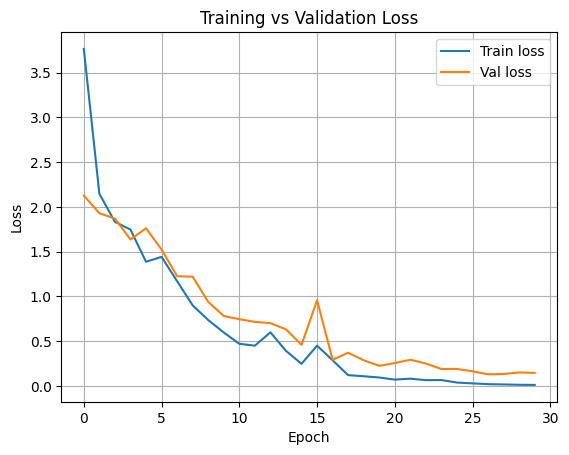

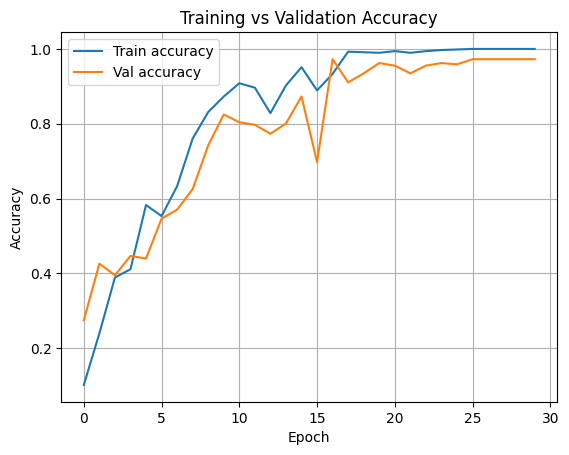

In [ ]:
plt.figure()
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

From the above plots we can conclude that the model learns the train dataset and can generalize to unseen data suprisingly well.

## 7. Create a CNN model

In [ ]:
cnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_size),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, activation='relu', use_bias=True),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, activation='relu', use_bias=True),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu', use_bias=True),
    tf.keras.layers.Dense(units=output_size, activation='softmax', use_bias=True)
], name='CNN')
cnn.summary()

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 31, 31, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 26912)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     3,444,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,456,298 (13.18 MB)

 Trainable params: 3,456,298 (13.18 MB)

 Non-trainable params: 0 (0.00 B)

The above convolutional neural network has 6 layers, apart from the input layer.

The first layer is a 2D convolutional layer with 32 feature maps (filters). The kernel size is 3 x 3 x 3 (the third dimension accounts for the RGB colors) and the stride is 2, while there is no zero padding. Thus, each feature map is of size: floor[ ( Input_size + 2 * padding - kernel_size ) / stride ] + 1 = floor[ (64 - 3) / 2 ] + 1 = 31, which means that the final output size of the first convolutional layer is: 31 x 31 x 32. A ReLU is also applied at the end of this layer. The total trainable parameters for this layer are calculated from the filters: weights = total_filters * (filter_size + bias) = 32 * (3 * 3 * 3 + 1) = 896.

The second layer is a dropout layer, with dropout probability 0.2.

The third layer is a convolutional layer which leads to output shape of 29 x 29 x 32 and 9248 trainable parameters.

The fourth layer is a flattening, which leads to an output size of 29 * 29 * 32 = 26912.

The next layer is a linear dense layer with 128 output length and (26912 + 1) * 128 = 3444864 trainable weights.

The final layer is also a dense layer with 10 outputs and (128 + 1) * 10 = 1290 parameters. The softmax is applies in this final layer, to acquire the classification probabilities and compare them with the one-hot encoding labels, as previously.




In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
cnn.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

history = cnn.fit(
    x_train,
    y_train_one_hot,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test_one_hot)
)

Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.1123 - loss: 2.5670 - val_accuracy: 0.2852 - val_loss: 2.2605
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.2364 - loss: 2.1562 - val_accuracy: 0.3746 - val_loss: 1.8084
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.5183 - loss: 1.4618 - val_accuracy: 0.5189 - val_loss: 1.2715
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.7512 - loss: 0.8568 - val_accuracy: 0.8763 - val_loss: 0.4989
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 0.9450 - loss: 0.2072 - val_accuracy: 0.9450 - val_loss: 0.3056
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.9733 - loss: 0.1443 - val_accuracy: 0.9691 - val_loss: 0.1393
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.9969 - loss: 0.0394 - val_accuracy: 0.9691 - val_loss: 0.1547
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 0.0129 - val_accuracy: 0.

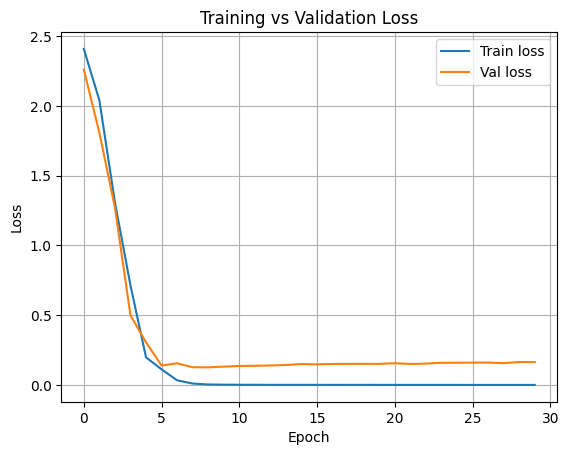

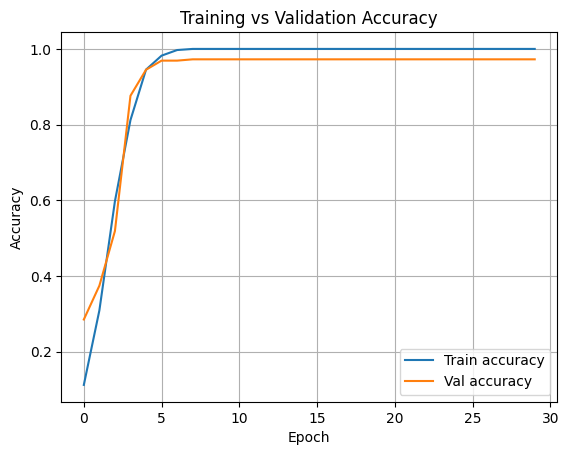

In [ ]:
plt.figure()
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

We can easily conclude that the CNN is clearly the best model for this specific dataset. This is because the CNN takes advantage of the spatial information of the images and detects different patterns with the different filters. Also, the dropout layer prevents the model from overfitting and leads to a fast convergence of the validation (test) accuracy to its maximum value.

On the other side, the MLP loses the spatial information with the necessary early flattening.

## 8. Improve the CNN model (if possible)

The model already fits perfectly the training data and can also generalize perfectly on the test data (training and test accuracies ~ 1). However, this probably happens because the dataset is small, so there is still room for improving the model's architecture, in order to generalize better in new, unseen data.

In [ ]:
x_val, x_test, y_val_one_hot, y_test_one_hot = train_test_split(x_test, y_test_one_hot, test_size=0.5, random_state=42)

x_val.shape, y_val_one_hot.shape, x_test.shape, y_test_one_hot.shape

((145, 64, 64, 3), (145, 10), (146, 64, 64, 3), (146, 10))

In [ ]:

epochs = 30
batch_size = 32


cnn2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_size),
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=2, activation='relu', use_bias=True),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, activation='relu', use_bias=True),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.3),


    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(units=128, activation='relu', use_bias=True),
    tf.keras.layers.Dense(units=output_size, activation='softmax', use_bias=True)
], name='CNN2')

cnn2.summary()


lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-6,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    restore_best_weights=True
)


optim = tf.keras.optimizers.Adam(learning_rate=0.001)
cnn2.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

history = cnn2.fit(
    x_train,
    y_train_one_hot,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val_one_hot),
    callbacks=[early_stopping, lr_scheduler]
)

Model: "CNN2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_47 (Conv2D)              │ (None, 31, 31, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 29, 29, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 29, 29, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 29, 29, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 26912)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 128)            │     3,444,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,451,370 (13.17 MB)

 Trainable params: 3,451,306 (13.17 MB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.4124 - loss: 3.2124 - val_accuracy: 0.4759 - val_loss: 2.1609 - learning_rate: 0.0010
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.9755 - loss: 0.1042 - val_accuracy: 0.5103 - val_loss: 1.9023 - learning_rate: 0.0010
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.5793 - val_loss: 1.7649 - learning_rate: 0.0010
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.6483 - val_loss: 1.6718 - learning_rate: 0.0010
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 6.2272e-04 - val_accuracy: 0.7448 - val_loss: 1.5710 - learning_rate: 0.0010
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 3.4299e-04 - val_accuracy: 0.8621 - val_loss: 1.4566 - learning_rate: 0.0010
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 4

In [ ]:
test_loss, test_acc = cnn2.evaluate(x_test, y_test_one_hot, verbose=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9921 - loss: 0.0631


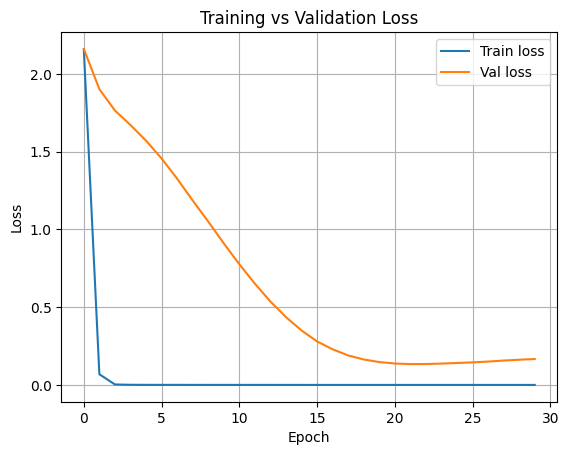

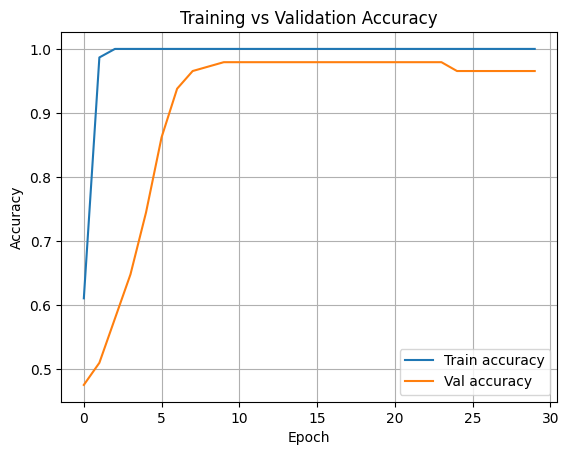

In [ ]:
plt.figure()
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

The initial model was pretty good at fitting the training data and also generalizing to unseen data, but with a room for improvement for the latter.

Thus, our goal is to apply tricks to simplify the model, in order to decrease its variance (thus decrease the validation loss and increase the validation accuracy). After a series of experimentation that failed miserably (:P), we narrowed down do the changes below:

1. In the first convolutional layer, apply 16 filters instead of 32. This will deacrease the number of feature maps this layer produces and thus reduce the model's complexity.

2. Apply a dropout layer in the end of the second convolutional layer, with a dropout probability of 0.3 (higher than before to help the model generalize slightly better).

3. Apply a learning rate scheduler with lr decay of factor 0.5 and patience 4.

4. Apply early stopping to keep the best version of the model. Indeed, the model's validation loss has a minimum at epoch 22/30, where val_loss = 0.1340. So, the early stopping trick keeps the model's weights from this epoch.

An important detail here is that we have split the data into 3 sets: train,validation and test with percentages 70,15,15 respectively. This split is necessary, because now the lr_scheduler and the early stopping rely on the validation set loss to determine the training/building of the model. Thus, we want a separate set, which is not involved in this process - the new test set.

Finally, we get better validation accuracy and loss (val_accuracy: 0.9793 - val_loss: 0.1340) than the original CNN model (where val_accuracy: 0.9725 - val_loss: 0.1638).

Also, we get high test accuracy and low test loss (accuracy: 0.9921 - loss: 0.0631). This means that the new model is capable of generalizing its knowledge to unseen data pretty well.